In [1]:
import torch
from qer.ai.hemorrhages import Hemorrhages2DBlend
import pandas as pd
from monai.data import Dataset
from torch.utils.data import DataLoader
import monai
import random
from typing import Any, Dict, List, Sequence, Union, Tuple, Optional

import numpy as np
import SimpleITK as sitk
import torch
import time
from loguru import logger
from monai.transforms import (
    DivisiblePadd,
    RandomizableTransform,
    Transform,
    Resize
)
from torch.nn.functional import interpolate
from skimage.transform import rescale
from pydicom import dcmread
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import torch.nn.functional as F
import h5py
from tqdm.auto import tqdm
from scipy import ndimage as ndi
import os
import torch
from qer.utils.db import get_mongo_db
db = get_mongo_db()
from qer.utils.imageoperations.resampler import load_raw_sitk_img
from monai.data import Dataset
import copy
import skimage.segmentation as skimg_segm
import sqlite3
from qer.ai.predictor.get_predictions import load_and_run_model
from skimage.morphology import skeletonize
from skimage.filters import median

Unable to find logging config yaml. Configuring fallback values


In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import widgets
from ipywidgets import interact


def plot_scans(img_arr_list, title_list):
    cols = len(img_arr_list)
    num_slices = img_arr_list[0].shape[0]

    def callback(z=None):
        fig, ax = plt.subplots(1, cols, figsize=(5*cols, 5*cols), squeeze=False)
        for idx in range(cols):
            ax[0][idx].imshow(img_arr_list[idx][z, :, :], cmap='gray')
            ax[0][idx].title.set_text(title_list[idx])
            ax[0][idx].axis('off')
            ax[0][idx].grid(False)

        fig.tight_layout()
        fig.show()

    interact(
        callback,
        z=widgets.IntSlider(value=0, min=0, max=(num_slices - 1), step=1)
    )

In [3]:
def draw_mask_boundary(image: np.ndarray, label_img: np.ndarray, color=(1, 1, 0)):
    image = copy.deepcopy(image)
    label_img = label_img.astype(np.uint8)
    image = (image - image.min()) / (image.max() - image.min())
    if len(image.shape) == 2:
        return skimg_segm.mark_boundaries(
            image,
            label_img,
            color=color,
            outline_color=None,
            mode="outer",
            background_label=0,
        )
    elif len(image.shape) == 3:
        imgs = []
        for idx in range(label_img.shape[0]):
            if label_img[idx].sum() != 0:
                imgs.append(draw_mask_boundary(image[idx], label_img[idx]))
                # imgs.append(np.stack([image[idx]] * 3, axis=2))
            else:
                imgs.append(np.stack([image[idx]] * 3, axis=2))
        return np.stack(imgs, axis=0)
    else:
        raise NotImplementedError(f"Only 3d or 2d images are supported., Given {image.shape}")


In [4]:
from qer.utils.preprocessing.windowing import window_generator
brain_window = window_generator(80 , 40)
blood_window = window_generator(175 , 50)
bone_window = window_generator(3000 , 500)

In [5]:
import pyrootutils
import hydra

root = pyrootutils.setup_root(search_from="./", indicator=[".git", "pyproject.toml"], pythonpath=True, dotenv=True)


In [7]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize("../configs/datamodule/", version_base="1.2")
data_module = hydra.compose("bleed_seg_datamodule.yaml")

In [8]:
datamodule = hydra.utils.instantiate(data_module)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

2023-09-06 08:24:27.766 | INFO     | src.datamodules.base_dataloader:setup:56 - Train set Length: 46
2023-09-06 08:24:27.767 | INFO     | src.datamodules.base_dataloader:setup:57 - Val set Length: 100
2023-09-06 08:24:27.767 | INFO     | src.datamodules.base_dataloader:setup:64 - Test set Length: 374


In [19]:
val_ds = datamodule.val_ds

In [9]:
test_ds = datamodule.test_ds


In [10]:
from src.common.nn_modules.nets.slicewise.multitaskold import MultiTaskFusionNet, modify_model_state_dict

In [11]:
# ckpt_path = "/data_nas5/qer/shubham/ich_checkpoints/ich_classification/runs/2023-08-02_09-46-35/checkpoints/epoch=21_step=2310_val_loss=1.01.ckpt"
ckpt_path = "/data_nas5/qer/shubham/epoch=17_step=396_val_loss=0.69.ckpt"

In [12]:
k = torch.load(ckpt_path,map_location = "cpu")
state_dict = k['state_dict']
new_state_dict = modify_model_state_dict(state_dict , "net.backbone" , "backbone")
new_state_dict = modify_model_state_dict(new_state_dict , "net.classification_head" , "classification_head")

In [9]:
# model = MultiTaskFusionNet()

import logging

import numpy as np
import segmentation_models_pytorch as smp
import torch
from segmentation_models_pytorch.base import ClassificationHead
from copy import deepcopy
from segmentation_models_pytorch.base import initialization as init
from loguru import logger

class MultiTaskFusionNet(torch.nn.Module):
    def __init__(
        self,
        cls_pooling = "avg",
        cls_dropout = 0.5,
        decoder_attention_type="scse",
    ):      
        super().__init__()
        
        encoder_name="se_resnext50_32x4d"
        architecture="Unet"
        in_chans = 3
        num_classes=2
        encoder_depth=5
        
        self.backbone = getattr(smp, architecture)(
            encoder_name=encoder_name,
            encoder_depth=encoder_depth,
            classes= num_classes,
            encoder_weights=None,
            decoder_attention_type=decoder_attention_type,
        )
        # self.init()

        copy_backbone = deepcopy(self.backbone)

        del copy_backbone.decoder
        del copy_backbone.segmentation_head

        v3_path = "/home/users/shubham.kumar/projects/qureai/packages/python/qer/resources/checkpoints/hemorrhages/seresnext50_scanwise_thin_noise_1_cycle.pth.tar"
        kwargs = {}
        kwargs["map_location"] = "cpu"
        checkpoint = torch.load(v3_path, **kwargs)

        ###################
        backbone_checkpoint = deepcopy(checkpoint)
        # win_opt_checkpoint = deepcopy(checkpoint)
        cls_head_checkpoint = deepcopy(checkpoint)
        ####################


        for key in ["win_opt.conv2d.weight", "win_opt.conv2d.bias", "multi_fc.fc_0.weight", "multi_fc.fc_0.bias"]:
            del backbone_checkpoint["model_state_dict"][key]
        new_state_dict = modify_model_state_dict(backbone_checkpoint["model_state_dict"], "backbone.encoder" , "encoder")

        copy_backbone.load_state_dict(new_state_dict)
        self.backbone.encoder = copy_backbone.encoder

        #################
        # for key in checkpoint["model_state_dict"].keys() :
        #     if key not in ["win_opt.conv2d.weight", "win_opt.conv2d.bias"] :
        #         del win_opt_checkpoint["model_state_dict"][key]

        # new_win_opt_state_dict = modify_model_state_dict(win_opt_checkpoint["model_state_dict"], "win_opt." , "")
        # self.win_opt.load_state_dict(new_win_opt_state_dict)
        ###################

        for key in checkpoint["model_state_dict"].keys() :
            if key not in ["multi_fc.fc_0.weight", "multi_fc.fc_0.bias"] :
                del cls_head_checkpoint["model_state_dict"][key]

        cls_head_checkpoint["model_state_dict"]["3.weight"] = cls_head_checkpoint["model_state_dict"]["multi_fc.fc_0.weight"]
        cls_head_checkpoint["model_state_dict"]["3.bias"] = cls_head_checkpoint["model_state_dict"]["multi_fc.fc_0.bias"]

        for key in ["multi_fc.fc_0.weight", "multi_fc.fc_0.bias"] :
            del cls_head_checkpoint["model_state_dict"][key]

        #########################

        self.num_features = self.backbone.encoder.out_channels[-1]
        self.num_features += self.backbone.segmentation_head[0].in_channels

        g = self.backbone.encoder(torch.rand(1, in_chans, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]

        self.classification_head = ClassificationHead(
            in_channels=encoder_channels[-1],
            classes= num_classes,
            pooling= cls_pooling,
            dropout= cls_dropout,
            activation=None,
        )

        self.classification_head.load_state_dict(cls_head_checkpoint["model_state_dict"])


    def init(self, expected_fraction=0.99):
        """Initialize model parameters.

        Initialize segmentation head so that background is predicted
        most of the time. This idea is from Focal Loss paper.
        """
        fill_0 = np.log(expected_fraction / (1 - expected_fraction)) / 2
        bias = self.backbone.segmentation_head[0].bias.data
        bias[0].fill_(fill_0)
        bias[1].fill_(-fill_0)

    def initialize(self):
        init.initialize_decoder(self.backbone.decoder)
        init.initialize_head(self.classification_head)

    def forward(self, x):

        # x = (b, 3, z, 224, 224)
        z_size = x.size(2)
        # fold z in to batch dimension
        x = x.transpose(1, 2).contiguous()       # (b, z, 3, 224, 224)
        x = x.view(-1, *x.size()[2:])            # (b*z, 3, 224, 224)

        features = self.backbone.encoder(x)            
        classification_out = self.classification_head(features[-1])  # (b*z , 2)
        slice_output = torch.split(classification_out, z_size)  # list of (b, z, 2)
        slice_output = torch.stack(slice_output)
        slice_output = torch.swapaxes(slice_output, 1 ,-1)  ## torch.Size([b, 2, z])

        scan_output = logsumexp_attention(slice_output)  # (b,2)

        outputs = {}
        outputs["slice_label"] = classification_out
        outputs["scan_label"] = scan_output

        decoder_output = self.backbone.decoder(*features)
        seg_output = self.backbone.segmentation_head(decoder_output)
        outputs["mask"] = torch.swapaxes(torch.stack(torch.split(seg_output, z_size)), 1 ,2)
        # logger.debug( outputs["mask"].shape)
        outputs["mask"] = outputs["mask"][:,1,:,:,:].unsqueeze(dim = 1)
        # logger.debug( outputs["mask"].shape)
        return outputs

    
def _lse_max(a, r=20, dim=0):
    log_n = torch.log(torch.tensor(a.shape[dim]).double())
    return 1 / r * (torch.logsumexp(a * r, dim=dim) - log_n)


def logsumexp_attention(a, beta=20):
    batchsize, ftrs, *shp = a.shape
    assert ftrs == 2
    a = a - a.mean(dim=1).unsqueeze(1)
    a_flat = a.view(batchsize, ftrs, -1)
    s_pos = _lse_max(a_flat[:, 1, :], r=beta, dim=1)
    s_neg = -s_pos
    s = torch.stack([s_neg, s_pos], dim=1)
    return s


def modify_model_state_dict(model_state_dict, old_prefix, new_prefix, modify_conv1x1=False):
    """Modify the prefixes in model_state_dict."""
    model_state_dict = {k.replace(old_prefix, new_prefix): v for k, v in model_state_dict.items()}

    if modify_conv1x1:
        conv1x1_keys = [k for k in model_state_dict.keys() if "multi_conv.conv1x1" in k]
        for k in conv1x1_keys:
            k_new = k.replace("multi_conv.conv1x1", "multi_fc.fc")
            model_state_dict[k_new] = model_state_dict[k].squeeze()
            del model_state_dict[k]

    return model_state_dict

In [10]:
model = MultiTaskFusionNet()

Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


In [11]:
image = sitk.ReadImage('/data_nas3/processed/hct/Test_set/test_set_1/sampled/1.2.840.113619.2.278.3.2831165733.829.1325445117.576.nii.gz')


In [12]:
arr = sitk.GetArrayFromImage(image)

In [13]:
img_tensor = torch.Tensor(arr)

In [14]:
img_tensor.shape

torch.Size([36, 512, 512])

In [15]:
model.load_state_dict(new_state_dict)
model.to("cuda:1")
model.eval()

MultiTaskFusionNet(
  (backbone): Unet(
    (encoder): SENetEncoder(
      (layer0): Sequential(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      )
      (layer1): Sequential(
        (0): SEResNeXtBottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, mo

In [20]:
li =[]


In [83]:
activation = torch.nn.Softmax(dim=1)

In [31]:
for i in tqdm(range(2000,3000)) :
    try :
        data = test_ds[i]
    #     if data['study_uid'] in done_study_uids :
    #         continue
    #     else:
    #     if data['image'].shape[1] <= 50 : 
        image = data['image'].unsqueeze(0).to("cuda:0")
        sdh_outputs = model(image)
        sdh_model_score = activation(sdh_outputs['scan_label'])
        sdh_score = sdh_model_score.detach().cpu().numpy()
        del sdh_outputs
        del image
        torch.cuda.empty_cache()
        li.append({"StudyUID": data['study_uid'] ,"sdh_model_score_crop": sdh_score[0][1]})
    except KeyboardInterrupt :
        break
    except Exception as e :
        print(e)
        

        

  0%|          | 0/1000 [00:00<?, ?it/s]

Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


CUDA out of memory. Tried to allocate 106.00 MiB (GPU 0; 23.70 GiB total capacity; 7.10 GiB already allocated; 61.81 MiB free; 7.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 23.70 GiB total capacity; 9.57 GiB already allocated; 153.81 MiB free; 10.01 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 23.70 GiB total capacity; 7.72 GiB already allocated; 25.81 MiB free; 7.92 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA o

CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 23.70 GiB total capacity; 7.91 GiB already allocated; 8.81 MiB free; 8.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 74.00 MiB (GPU 0; 23.70 GiB total capacity; 8.27 GiB already allocated; 8.81 MiB free; 8.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 23.70 GiB total capacity; 7.91 GiB already allocated; 8.81 MiB free; 8.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of m

In [21]:
i = 0
data = test_ds[i]
   
image = data['image'].unsqueeze(0).to("cuda:1")
sdh_outputs = model(image)
sdh_model_score = activation(sdh_outputs['scan_label'])
sdh_score = sdh_model_score.detach().cpu().numpy()

# li.append({"StudyUID": data['study_uid'] ,"sdh_model_score_crop": sdh_score[0][1]})

RuntimeError: applying transform <monai.transforms.compose.Compose object at 0x7fad37ae76d0>

In [32]:
len(li)

2953

In [33]:
df = pd.DataFrame.from_records(li)

In [34]:
df.to_csv("fusion_v5_crop_new_test_set.csv",index =False)

In [21]:
#df.to_csv("fusion_v5_crop_qure25k.csv",index =False)

In [28]:
df_fusion = pd.read_csv("fusion_v5_crop_qure25k.csv")

In [26]:
pd.concat([df_fusion , df])

,StudyUID,sdh_model_score_crop
0,1.2.840.113619.2.55.3.2831165733.330.150070896...,0.993199
1,ID_217af942ce,0.031613
2,1.2.840.113619.2.278.3.2831165733.814.13260709...,0.335875
3,ID_3fd32f9620,0.144307
4,1.2.840.113704.1.111.3328.1496933588.1,0.989025
...,...,...
20747,ID_a829a49e2a,0.984411
20748,1.2.840.113619.2.55.3.2831165736.637.150966233...,0.050575
20749,1.2.840.113619.2.55.3.2831165735.212.151110809...,0.975797
20750,ID_f8c80cd805,0.995136


In [27]:
#pd.concat([df_fusion , df]).to_csv("fusion_v5_crop_qure25k.csv" ,index =False)

In [33]:
done_study_uids = list(set(df_fusion.StudyUID.values))

In [22]:
df_final = pd.concat([df_fusion , df])

In [24]:
#df_final.drop_duplicates(subset = ["StudyUID"]).to_csv("fusion_v5_crop.csv" ,index =False)

In [98]:
df_fusion

,StudyUID,sdh_model_score_crop
0,1.2.840.113619.2.81.290.1.892.20170307.234045,0.023763
1,1.2.840.113696.513556.510.1411822.20200204205816,0.093300
2,ID_226b09f336,0.017558
3,ID_f0968c215b,0.058251
4,1.2.840.113619.2.55.3.2831165756.520.138768265...,0.576768
...,...,...
4368,1.3.6.1.4.1.25403.52231229397.5424.20170807102...,0.266037
4369,ID_51f2e734c9,0.027206
4370,ID_4f145f621d,0.753787
4371,1.3.12.2.1107.5.1.4.31128.30000011122903391196...,0.045055


In [99]:
df_fusion = df_fusion.rename(columns = {"sdh_model_score_crop" : "sdh_model_score_crop_fusion"})

In [100]:
df_v3 = pd.read_csv("output_blend_v3_only_negative_ICH.csv")

In [101]:
df_v3

,StudyUID,blend_score,hemorrhages_v3
0,1.2.840.113619.2.81.290.1.892.20170307.234045,0.040334,0.006555
1,1.2.840.113696.513556.510.1411822.20200204205816,0.137214,0.258907
2,ID_226b09f336,0.022057,0.002750
3,ID_f0968c215b,0.147108,0.034212
4,1.2.840.113619.2.55.3.2831165756.520.138768265...,0.517809,0.435113
...,...,...,...
5295,1.2.840.113619.2.55.3.2831165733.162.151056206...,0.350086,0.366941
5296,1.3.6.1.4.1.25403.52231229397.1684.20171116034...,0.668997,0.777496
5297,1.3.12.2.1107.5.1.4.31128.30000014110705474268...,0.053483,0.023871
5298,1.2.840.113619.2.55.3.2831165743.897.150829424...,0.113209,0.028938


In [11]:
df_v3net = pd.read_csv("v3net_crop.csv")

In [14]:
df_v3net = df_v3net.rename(columns = {"sdh_model_score_crop" : "sdh_model_score_crop_v3net"})

In [18]:
df_merge1 = pd.merge(df_v3net, df_fusion, how = "inner" , on = "StudyUID")

In [19]:
df_final = pd.merge(df_merge1,df_v3 ,  how = "inner" , on = "StudyUID")

In [10]:
df_final = pd.read_csv("final_test_ICH.csv")

In [80]:
minp = 0
p = 0.2
condition_col1 = (df_final['sdh_model_score_crop_v3net'] >= minp) & (df_final['sdh_model_score_crop_v3net'] < p)
condition_col2 = (df_final['sdh_model_score_crop_fusion'] >= minp) & (df_final['sdh_model_score_crop_fusion'] < p)
condition_col3 = (df_final['hemorrhages_v3'] >= minp) & (df_final['hemorrhages_v3'] < p)

combined_condition = condition_col1 & condition_col2 & condition_col3

filtered_df = df_final[combined_condition]

In [81]:
study_uids = filtered_df.StudyUID.values

In [82]:
len(study_uids)

64

In [93]:
suid = study_uids[1]

In [94]:
print(db.dicoms.find_one({"_id": suid})["Report"]["Text"])

PROCEDURE INFORMATION: 
Exam: CT Head Without Contrast 
Exam date and time: [PHI DATE] 
Clinical history: [PHI XXX YRS] old, male; Injury or trauma; Fall 

TECHNIQUE: 
Imaging protocol: Computed tomography of the head without contrast. 
Radiation optimization: All CT scans at this facility use at least one of these dose optimization techniques: automated exposure control; mA and/or kV adjustment per patient size (includes targeted exams where dose is matched to clinical indication); or iterative reconstruction. 

COMPARISON: 
CT IAC W- &W/O CONTRAST [PHI DATE] 

FINDINGS: 
Brain: Small densities seen within the CSF spaces anterior to the frontal lobes could represent small subacute subdural hemorrhages. These are isodense to adjacent brain parenchyma. No signs of acute hemorrhage. Age-related involutional changes of the brain with scattered white matter hypodensities most compatible with chronic microangiopathy. No hemorrhage, mass or other acute findings. 
Ventricles: No ventriculomeg

In [15]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize("../configs/datamodule/transforms/", version_base="1.2")
transforms = hydra.compose("tf.yaml")

In [16]:
tf = hydra.utils.instantiate(transforms)

In [17]:
tf

{'val_transforms': <monai.transforms.compose.Compose object at 0x7f3588126310>, 'train_transforms': <monai.transforms.compose.Compose object at 0x7f352b3e6eb0>}

In [66]:
study_dict = db.dicoms.find_one({"_id": suid})

for series in study_dict["SeriesList"]:
    print(series["NumInstances"], series['SeriesInstanceUID'] , series["SeriesNumber"])

1 1.3.12.2.1107.5.1.4.105141.30000019111111255211300004171 1
1 1.3.12.2.1107.5.1.4.105141.30000019111111255211300004182 2
1 1.3.12.2.1107.5.1.4.105141.30000019111111255211300004453 501
41 1.3.12.2.1107.5.1.4.105141.30000019111111445387000039416 4
41 1.3.12.2.1107.5.1.4.105141.30000019111111445387000039458 5
44 1.3.12.2.1107.5.1.4.105141.30000019111111445387000040180 6
71 1.3.12.2.1107.5.1.4.105141.30000019111111445387000040226 7
62 1.3.12.2.1107.5.1.4.105141.30000019111111445387000040299 8
71 1.3.12.2.1107.5.1.4.105141.30000019111111445387000040363 9
62 1.3.12.2.1107.5.1.4.105141.30000019111111445387000040436 10


In [71]:
series_dict = db.dicoms.find_one({"_id": '1.3.12.2.1107.5.1.4.105141.30000019111111445387000039416'})

In [72]:
filepaths = [x['FilePath'] for x in series_dict["InstancesList"]]

In [75]:
filepaths = [filepath.replace( "/data_nas2/raw/" , "/data_nas3/raw/hct/")  for filepath in filepaths]

filepaths = [filepath.replace( "/data_nas2/processed/HeadCT/" , "/data_nas3/processed/hct/")  for filepath in filepaths]

In [76]:
sitk_img = load_raw_sitk_img(filepaths)

2023-08-07 10:28:58,805 - Correcting image z spacing using median of slice positions from 5.00 to 5.00


In [77]:
arr = sitk.GetArrayFromImage(sitk_img)

In [78]:
req_vol = brain_window(arr) - blood_window(arr) 
req_vol[req_vol<0] =0
plot_scans([brain_window(arr) ,blood_window(arr), req_vol] , ["brain_window", "blood_window",""])

interactive(children=(IntSlider(value=0, description='z', max=40), Output()), _dom_classes=('widget-interact',…

In [26]:
image = torch.Tensor(np.stack([brain_window(arr) , blood_window(arr), bone_window(arr)]))

In [25]:
data = {"image" : torch.Tensor(arr)}

In [26]:
ds = Dataset([data], transform= tf.val_transforms)

In [27]:
image= ds[0]['image']

In [28]:
image.shape

torch.Size([3, 272, 224, 224])

In [29]:
split_tensor = torch.split(image , 32,1)

In [30]:
len(split_tensor)

9

In [31]:
activation = torch.nn.Softmax(dim=1)

In [33]:
output = []
for k in range(4, len(split_tensor)) : 
    sdh_outputs = model(split_tensor[k].unsqueeze(0).to("cuda:1"))
    print(activation(sdh_outputs['scan_label']))
    output.append(sdh_outputs['slice_label'])
    del sdh_outputs
    torch.cuda.empty_cache()

Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


tensor([[0.9461, 0.0539]], device='cuda:1', grad_fn=<SoftmaxBackward0>)
tensor([[0.9283, 0.0717]], device='cuda:1', grad_fn=<SoftmaxBackward0>)
tensor([[0.9164, 0.0836]], device='cuda:1', grad_fn=<SoftmaxBackward0>)
tensor([[0.8567, 0.1433]], device='cuda:1', grad_fn=<SoftmaxBackward0>)


RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 1; 23.65 GiB total capacity; 21.74 GiB already allocated; 96.56 MiB free; 22.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [36]:
for k in range(4, len(split_tensor)) : 
    sdh_outputs = model(split_tensor[k].unsqueeze(0).to("cuda:0"))
    print(activation(sdh_outputs['scan_label']))
    output.append(sdh_outputs['slice_label'])
    del sdh_outputs
    torch.cuda.empty_cache()

tensor([[0.1750, 0.8250]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.9047, 0.0953]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.4713, 0.5287]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.5204, 0.4796]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.9757, 0.0243]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [32]:
sdh_outputs = model(split_tensor[4].unsqueeze(0).to("cuda:0"))

Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


In [48]:
seg_mask = activation(sdh_outputs["mask"])

In [49]:
seg_mask_arr = seg_mask.squeeze().detach().cpu().numpy()

In [50]:
seg_mask_arr.shape

(2, 32, 224, 224)

In [40]:
data['image'].shape

torch.Size([3, 272, 224, 224])

In [43]:
split_tensor[4][0].numpy()

torch.Size([32, 224, 224])

In [59]:
overlayed = draw_mask_boundary(split_tensor[4][0].numpy() , seg_mask_arr[1]>0.5)

In [60]:
plot_scans([overlayed] , [""])

interactive(children=(IntSlider(value=0, description='z', max=31), Output()), _dom_classes=('widget-interact',…

In [86]:
df_external_set = pd.read_json("/cache/fast_data_nas8/qer/ujjwal/npy_cached_external_data/jsons/external_set.json")

In [89]:
df_external_set.filepath.values[0]

'/cache/fast_data_nas8/qer/ujjwal/npy_cached_external_data/data/1.2.840.113619.2.332.3.2830503685.12.1660871541.510.3.npy'

In [90]:
test_arr = np.load(df_external_set.filepath.values[0])

In [92]:
plot_scans([brain_window(test_arr)] , [""])

interactive(children=(IntSlider(value=0, description='z', max=34), Output()), _dom_classes=('widget-interact',…

In [95]:
df = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/test_negative_ICH_sampled.csv")

In [35]:
df_v3net_qure_25k =  pd.concat([pd.read_csv("output_blend_v3_only.csv") , pd.read_csv("output_blend_v3_only_negative_ICH.csv") , pd.read_csv("v3net_crop_qure_25k.csv")])


In [33]:
# df_fusion_qure_25k.to_csv("v3net_qure25k_output.csv", index =False)

In [64]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [37]:
#df_v3net_qure_25k.to_csv("v3net_qure25k_output.csv", index =False)

In [ ]:
he_blend = Hemorrhages2DBlend(debug_mode= True,)

In [57]:
df_train = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_train.csv")

In [61]:
normal_series_uids = df_train[df_train["NORMAL_BRAIN"] == 1].SeriesUID.values

In [44]:
#f = h5py.File("/cache/fast_data_nas8/qer/sujith/1.2.840.113619.2.55.3.2831165733.330.1500708960.62.h5","r")

In [47]:
#arr = np.array(f["image"])

In [7]:
import sqlite3
root_dir = "/data_nas3/processed/hct/Cache/all_imgs_cache.dcm/"

path = "/home/users/shubham.kumar/projects/ICH_classification_segmentation/qct_training_framework/hemorrhage_annotations.sqlite"
con = sqlite3.connect(path)
df_hemorrhage_mask = pd.read_sql_query("SELECT * from hemorrhage_annotations", con)
con.close()


def get_mask_arr_path(study_uid):
    rows = df_hemorrhage_mask[df_hemorrhage_mask.StudyUID == study_uid]
    if len(rows) > 0:
        study_uid = rows.iloc[0].StudyUID
        mask_path = rows.iloc[0].MaskPath[:-7]
        filepath = os.path.join(root_dir, mask_path)
        filenames = []
        for slice_ in range(len(os.listdir(filepath))):
            slice_num = (3 - len(str(slice_))) * "0" + str(slice_)
            data_path = os.path.join(filepath, f"image_{slice_num}.dcm")
            filenames.append(data_path)
        return filenames
    return -100


In [8]:
series_dict = db.dicoms.find_one({"_id": df_hemorrhage_mask.SeriesUID.values[0]})
filepaths = [x['FilePath'] for x in series_dict["InstancesList"]]
filepaths = [filepath.replace( "/data_nas2/raw/" , "/data_nas3/raw/hct/")  for filepath in filepaths]
# filepaths = [filepath.replace( "/data_nas2/processed/HeadCT/" , "/data_nas3/processed/hct/")  for filepath in filepaths]


NameError: name 'db' is not defined

In [17]:
sitk_img = load_raw_sitk_img(filepaths)

2023-08-09 09:11:31,869 - Correcting image z spacing using median of slice positions from 5.08 to 5.08


ImageSeriesReader (0x239f4690): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000516129



In [94]:
output = load_and_run_model("mls_helper_icv_quant",sitk_img)

midline_output = load_and_run_model("mls_quantification" ,sitk_img)

[2023-08-09 09:56:23 +0530] [INFO] Loading model mls_helper_icv_quant
[2023-08-09 09:56:26 +0530] [INFO] Loading model mls_quantification
[2023-08-09 09:56:28 +0530] [INFO] Loading model mls_helper_icv_quant
[2023-08-09 09:56:31 +0530] [INFO] Loading model mls_helper_lv_quant


In [96]:
mls_arr = sitk.GetArrayFromImage(midline_output['results']['heatmaps']['MLS'])

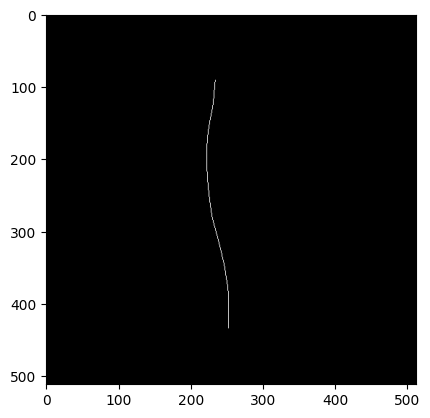

In [215]:
plt.imshow(mls_arr[14] ,cmap = 'gray')
plt.show()

In [216]:
np.argwhere(mls_arr[14]==1)

array([[ 91, 234],
       [ 92, 234],
       [ 93, 234],
       [ 94, 233],
       [ 95, 233],
       [ 96, 233],
       [ 97, 233],
       [ 98, 233],
       [ 99, 233],
       [100, 233],
       [101, 233],
       [102, 233],
       [103, 233],
       [104, 233],
       [105, 232],
       [106, 232],
       [107, 232],
       [108, 232],
       [109, 232],
       [110, 232],
       [111, 232],
       [112, 232],
       [113, 232],
       [114, 232],
       [115, 232],
       [116, 232],
       [117, 231],
       [118, 231],
       [119, 231],
       [120, 231],
       [121, 231],
       [122, 231],
       [123, 231],
       [124, 231],
       [125, 231],
       [126, 230],
       [127, 230],
       [128, 230],
       [129, 230],
       [130, 230],
       [131, 230],
       [132, 229],
       [133, 229],
       [134, 229],
       [135, 229],
       [136, 229],
       [137, 228],
       [138, 228],
       [139, 228],
       [140, 228],
       [141, 228],
       [142, 227],
       [143,

In [21]:
icv_mask = output['results']['heatmaps']['ICV']

In [22]:
icv_mask_arr = sitk.GetArrayFromImage(icv_mask)

In [23]:
arr= sitk.GetArrayFromImage(sitk_img)

In [672]:
import skimage
from skimage.morphology import ball , disk , binary_erosion , binary_dilation, binary_closing, binary_opening

In [25]:
eroded_icv_mask_arr = icv_mask_arr.copy()

In [26]:
for i in range(eroded_icv_mask_arr.shape[0]):
    eroded_icv_mask_arr[i] = binary_erosion(icv_mask_arr[i], disk(6))

In [28]:
dcm_paths = get_mask_arr_path(df_hemorrhage_mask.StudyUID.values[0])
arr_list = [dcmread(dcm_path).pixel_array for dcm_path in dcm_paths]
sdh_mask_arr = np.array(arr_list)

In [103]:
contour = icv_mask_arr-eroded_icv_mask_arr

In [105]:
plot_scans([brain_window(arr), icv_mask_arr , contour , sdh_mask_arr] , ["","","",""])

interactive(children=(IntSlider(value=0, description='z', max=31), Output()), _dom_classes=('widget-interact',…

In [523]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Compute the histogram of pixel values within the masked region
hu_values = arr[binary_erosion(sdh_mask_arr,ball(1)) > 0].ravel()

In [6]:
import random
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize, rosen, rosen_der
import random


class Point(object):
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y

    def random(self, min= 0, max= 1):
        self.x = random.uniform(min,max)
        self.y = random.uniform(min,max)

#
#=============Cubic Bezier curve====================
#
class CubicBezier(object):
    def __init__(self, p0x= 0, p0y= 0, p1x= 0, p1y= 0, p2x= 0, p2y= 0, p3x= 0, p3y= 0):
        self.p0 = Point(p0x, p0y)
        self.p1 = Point(p1x, p1y)
        self.p2 = Point(p2x, p2y)
        self.p3 = Point(p3x, p3y)
        self.obstacles = []

    def random(self, min= 0, max= 1):
        'Create a random cubic Bezier curve within [min, max] limits. Default [0,1].'
        self.p0.random(min, max)
        self.p1.random(min, max)
        self.p2.random(min, max)
        self.p3.random(min, max)

    def max_k(self, granuality=100):
        'Calculate maximal curvature of the cubic Bezier curve.'
        k = 0
        for t in range(0, granuality):
            t = t / granuality
            x_d = 3 * ((1 - t) ** 2) * (self.p1.x - self.p0.x) + 6 * (1 - t) * t * (self.p2.x - self.p1.x) + 3 * (t ** 2) * (
                        self.p3.x - self.p2.x)
            y_d = 3 * ((1 - t) ** 2) * (self.p1.y - self.p0.y) + 6 * (1 - t) * t * (self.p2.y - self.p1.y) + 3 * (t ** 2) * (
                        self.p3.y - self.p2.y)
            x_dd = 6 * (1 - t) * (self.p2.x - 2 * self.p1.x + self.p0.x) + 6 * t * (self.p3.x - 2 * self.p2.x + self.p1.x)
            y_dd = 6 * (1 - t) * (self.p2.y - 2 * self.p1.y + self.p0.y) + 6 * t * (self.p3.y - 2 * self.p2.y + self.p1.y)
            k = max(k,abs(x_d*y_dd - y_d*x_dd)/math.pow(x_d**2 + y_d**2, 3/2))
        return k

    def calc_curve(self, granuality=100):
        'Calculate the cubic Bezier curve with the given granuality.'
        B_x = []
        B_y = []
        for t in range(0, granuality):
            t = t / granuality
            x = ((1 - t) ** 3) * self.p0.x + 3 * ((1 - t) ** 2) * t * self.p1.x + 3 * (1 - t) * (t ** 2) * self.p2.x\
                + (t ** 3) * self.p3.x
            y = ((1 - t) ** 3) * self.p0.y + 3 * ((1 - t) ** 2) * t * self.p1.y + 3 * (1 - t) * (t ** 2) * self.p2.y\
                + (t ** 3) * self.p3.y
            B_x.append(x)
            B_y.append(y)
        return [B_x, B_y]

    def plot(self, granuality=100):
        'Plot the cubic Bezier curve.'
        B = self.calc_curve(granuality)
        plt.plot(B[0], B[1])
        plt.scatter([self.p0.x,self.p1.x,self.p2.x,self.p3.x], [self.p0.y,self.p1.y,self.p2.y,self.p3.y])
        for i in range(len(self.obstacles)):
            plt.gcf().gca().add_artist(plt.Circle((self.obstacles[i][0].x, self.obstacles[i][0].y), self.obstacles[i][1], color='r'))
        plt.axis('equal')
        plt.show()

    def arc_len(self, granuality=1000):
        'Calculate the arc-length of the cubic Bezier curve.'
        B = self.calc_curve(granuality=granuality)
        a_l = 0

        for i in range(1,len(B[0])):
            a_l += math.sqrt((B[0][i]-B[0][i-1])**2 + (B[1][i]-B[1][i-1])**2)

        return a_l

    def optimize_k(self, granuality= 100, obs= True):
        'Optimize the cubic Bezier curve to minimize the curvature. By setting obs=False, ignore the obstacles.'
        x0 = [0.0, 0.0, 0.0, 0.0]
        res = minimize(self.optimizer_k, x0, args= (granuality, obs), method='Nelder-Mead', tol=1e-7)
        self.p1.x = self.p1.x + res.x[0]
        self.p1.y = self.p1.y + res.x[1]
        self.p2.x = self.p2.x + res.x[2]
        self.p2.y = self.p2.y + res.x[3]

    def optimizer_k(self,x, *args):
        'Curvature optimizer function.'
        granuality = args[0]
        obs = args[1]
        o = CubicBezier()
        o.p0 = self.p0
        o.p1.x = self.p1.x+x[0]
        o.p1.y = self.p1.y+x[1]
        o.p2.x = self.p2.x + x[2]
        o.p2.y = self.p2.y + x[3]
        o.p3 = self.p3
        penalty = 0

        if obs:
            B = o.calc_curve(granuality)
            for i in range(len(B[0])):
                for j in range(len(self.obstacles)):
                    d = math.sqrt((B[0][i] - self.obstacles[j][0].x)**2 + (B[1][i] - self.obstacles[j][0].y)**2)
                    if d<self.obstacles[j][1]:
                        penalty += (self.obstacles[j][1]-d)*100
        return o.max_k(granuality) + penalty

    def optimize_l(self, granuality= 100, obs= True):
        'Optimize the cubic Bezier curve to minimize the arc-length. By setting obs=False, ignore the obstacles.'
        x0 = [0.0, 0.0, 0.0, 0.0]
        res = minimize(self.optimizer_l, x0, args=(granuality, obs), method='Nelder-Mead', tol=1e-7)
        self.p1.x = self.p1.x + res.x[0]
        self.p1.y = self.p1.y + res.x[1]
        self.p2.x = self.p2.x + res.x[2]
        self.p2.y = self.p2.y + res.x[3]

    def optimizer_l(self,x, *args):
        'Arc-length optimizer function.'
        granuality = args[0]
        obs = args[1]
        o = CubicBezier()
        o.p0 = self.p0
        o.p1.x = self.p1.x+x[0]
        o.p1.y = self.p1.y+x[1]
        o.p2.x = self.p2.x + x[2]
        o.p2.y = self.p2.y + x[3]
        o.p3 = self.p3

        penalty = 0
        if obs:
            B = o.calc_curve(granuality)
            for i in range(len(B[0])):
                for j in range(len(self.obstacles)):
                    d = math.sqrt((B[0][i] - self.obstacles[j][0].x)**2 + (B[1][i] - self.obstacles[j][0].y)**2)
                    if d<self.obstacles[j][1]:
                        penalty += (self.obstacles[j][1]-d)*100

        return o.arc_len(granuality) + penalty

    def optimize(self, granuality=100, obs=True, l_multiplier=0.5, k_multiplier=0.5):
        """
        Optimize the cubic Bezier curve to simultaniously minimize the arc-lenght and the curvature.
        Setting obs=False ignores the obstacles. l_multiplier and k_multiplier multiplies
        the outputs of their respective optimizer functions.
        """
        x0 = [0.0, 0.0, 0.0, 0.0]
        res = minimize(self.optimizer, x0, args=(granuality, obs, l_multiplier, k_multiplier), method='Nelder-Mead', tol=1e-7)
        self.p1.x = self.p1.x + res.x[0]
        self.p1.y = self.p1.y + res.x[1]
        self.p2.x = self.p2.x + res.x[2]
        self.p2.y = self.p2.y + res.x[3]

    def optimizer(self,x,*args):
        'Optimizer function of the arc-length and curvature simultanious optimization.'
        granuality = args[0]
        obs = args[1]
        l_multiplier = args[2]
        k_multiplier = args[3]

        return self.optimizer_l(x, granuality, obs) * l_multiplier + self.optimizer_k(x, granuality, obs) * k_multiplier

    def add_obstacle(self, x=0, y=0, radius=0):
        'Add an obstacle to the cubic Bezier curve.'
        self.obstacles.append([Point(x,y), radius])

    def add_random_obstacle(self, min_x= 1, max_x= 0, min_y=1, max_y=0, min_radius=0.3, max_radius = 0.0):
        """Add a random obstacle to the cubic Bezier curve. The obstacle will not cover the p0 and p3 points
        of the Bezier curve.
        """
        radius = random.uniform(min_radius,max_radius)

        d = 0
        x = 0
        y = 0
        while d<radius:
            x = random.uniform(min_x,max_x)
            y = random.uniform(min_y,max_y)
            d1 = math.sqrt((x - self.p0.x)**2 + (y - self.p0.y)**2)
            d2 = math.sqrt((x - self.p3.x) ** 2 + (y - self.p3.y) ** 2)
            d = min(d1,d2)

        self.obstacles.append([Point(x, y), radius])

    def clear(self):
        'Re-initialize the curve.'
        self.__init__()


#
#=============Quadratic Bezier curve====================
#
class QuadBezier(object):
    def __init__(self, p0x= 0, p0y= 0, p1x= 0, p1y= 0, p2x= 0, p2y= 0):
        self.p0 = Point(p0x, p0y)
        self.p1 = Point(p1x, p1y)
        self.p2 = Point(p2x, p2y)
        self.obstacles = []

    def random(self,min= 0, max= 1):
        'Create a random quadratic Bezier curve within [min, max] limits. Default [0,1].'
        self.p0.random(min, max)
        self.p1.random(min, max)
        self.p2.random(min, max)

    def max_k(self, granuality=100):
        'Calculate maximal curvature of the quadratic Bezier curve.'
        k = 0
        for t in range(0, granuality):
            t = t / granuality
            x_d = 2 * (t - 1)*(self.p1.x - self.p0.x) + 2 * t * (self.p2.x - self.p1.x)
            y_d = 2 * (t - 1)*(self.p1.y - self.p0.y) + 2 * t * (self.p2.y - self.p1.y)
            x_dd = 2 * (self.p2.x - 2 * self.p1.x + self.p0.x)
            y_dd = 2 * (self.p2.y - 2 * self.p1.y + self.p0.y)
            k = max(k,abs(x_d*y_dd - y_d*x_dd)/math.pow(x_d**2 + y_d**2, 3/2))
        return k

    def calc_curve(self, granuality=100):
        'Calculate the quadratic Bezier curve with the given granuality.'
        B_x = []
        B_y = []
        for t in range(0, granuality):
            t = t / granuality
            x = self.p1.x + (1 - t)**2 * (self.p0.x-self.p1.x) + t**2 * (self.p2.x - self.p1.x)
            y = self.p1.y + (1 - t)**2 * (self.p0.y-self.p1.y) + t**2 * (self.p2.y - self.p1.y)
            B_x.append(x)
            B_y.append(y)
        return [B_x, B_y]

    def plot(self, granuality=100):
        'Plot the quadratic Bezier curve.'
        B = self.calc_curve(granuality)
        plt.plot(B[0], B[1])
        plt.scatter([self.p0.x,self.p1.x,self.p2.x], [self.p0.y,self.p1.y,self.p2.y])
        for i in range(len(self.obstacles)):
            plt.gcf().gca().add_artist(plt.Circle((self.obstacles[i][0].x, self.obstacles[i][0].y), self.obstacles[i][1], color='r'))
        plt.axis('equal')
        plt.show()

    def arc_len(self, granuality=1000):
        'Calculate the arc-length of the quadratic Bezier curve.'
        B = self.calc_curve(granuality=granuality)
        a_l = 0
        for i in range(1,len(B[0])):
            a_l += math.sqrt((B[0][i]-B[0][i-1])**2 + (B[1][i]-B[1][i-1])**2)
        return a_l

    def optimize_k(self, granuality= 100, obs= True):
        'Optimize the quadratic Bezier curve to minimize the curvature. By setting obs=False, ignore the obstacles.'
        x0 = [0.0, 0.0]
        res = minimize(self.optimizer_k, x0, args= (granuality, obs), method='Nelder-Mead', tol=1e-7)
        self.p1.x = self.p1.x + res.x[0]
        self.p1.y = self.p1.y + res.x[1]

    def optimizer_k(self,x, *args):
        'Curvature optimizer function.'
        granuality = args[0]
        obs = args[1]
        o = QuadBezier()
        o.p0 = self.p0
        o.p1.x = self.p1.x+x[0]
        o.p1.y = self.p1.y+x[1]
        o.p2 = self.p2
        penalty = 0

        if obs:
            B = o.calc_curve(granuality)
            for i in range(len(B[0])):
                for j in range(len(self.obstacles)):
                    d = math.sqrt((B[0][i] - self.obstacles[j][0].x)**2 + (B[1][i] - self.obstacles[j][0].y)**2)
                    if d<self.obstacles[j][1]:
                        penalty += (self.obstacles[j][1]-d)*100
        return o.max_k(granuality) + penalty

    def optimize_l(self, granuality= 100, obs= True):
        'Optimize the quadratic Bezier curve to minimize the arc-length. By setting obs=False, ignore the obstacles.'
        x0 = [0.0, 0.0]
        res = minimize(self.optimizer_l, x0, args=(granuality, obs), method='Nelder-Mead', tol=1e-7)
        self.p1.x = self.p1.x + res.x[0]
        self.p1.y = self.p1.y + res.x[1]

    def optimizer_l(self,x, *args):
        'Arc-length optimizer function.'
        granuality = args[0]
        obs = args[1]
        o = QuadBezier()
        o.p0 = self.p0
        o.p1.x = self.p1.x+x[0]
        o.p1.y = self.p1.y+x[1]
        o.p2 = self.p2

        penalty = 0
        if obs:
            B = o.calc_curve(granuality)
            for i in range(len(B[0])):
                for j in range(len(self.obstacles)):
                    d = math.sqrt((B[0][i] - self.obstacles[j][0].x)**2 + (B[1][i] - self.obstacles[j][0].y)**2)
                    if d<self.obstacles[j][1]:
                        penalty += (self.obstacles[j][1]-d)*100

        return o.arc_len(granuality) + penalty

    def optimize(self, granuality=100, obs=True, l_multiplier=0.5, k_multiplier=0.5):
        """
        Optimize the quadratic Bezier curve to simultaniously minimize the arc-lenght and the curvature.
        Setting obs=False ignores the obstacles. l_multiplier and k_multiplier multiplies
        the outputs of their respective optimizer functions.
        """
        x0 = [0.0, 0.0]
        res = minimize(self.optimizer, x0, args=(granuality, obs, l_multiplier, k_multiplier), method='Nelder-Mead', tol=1e-7)
        self.p1.x = self.p1.x + res.x[0]
        self.p1.y = self.p1.y + res.x[1]

    def optimizer(self,x,*args):
        'Optimizer function of the arc-length and curvature simultanious optimization.'
        granuality = args[0]
        obs = args[1]
        l_multiplier = args[2]
        k_multiplier = args[3]

        return self.optimizer_l(x, granuality, obs) * l_multiplier + self.optimizer_k(x, granuality, obs) * k_multiplier

    def add_obstacle(self, x=0, y=0, radius=0):
        'Add an obstacle to the quadratic Bezier curve.'
        self.obstacles.append([Point(x,y), radius])

    def add_random_obstacle(self, min_x= 1, max_x= 0, min_y=1, max_y=0, min_radius=0.3, max_radius = 0.0):
        """Add a random obstacle to the quadratic Bezier curve. The obstacle will not cover the p0 and p2 points
        of the Bezier curve.
        """
        radius = random.uniform(min_radius,max_radius)

        d = 0
        x = 0
        y = 0
        while d<radius:
            x = random.uniform(min_x,max_x)
            y = random.uniform(min_y,max_y)
            d1 = math.sqrt((x - self.p0.x)**2 + (y - self.p0.y)**2)
            d2 = math.sqrt((x - self.p2.x) ** 2 + (y - self.p2.y) ** 2)
            d = min(d1,d2)

        self.obstacles.append([Point(x, y), radius])

    def clear(self):
        'Re-initialize the curve.'
        self.__init__()


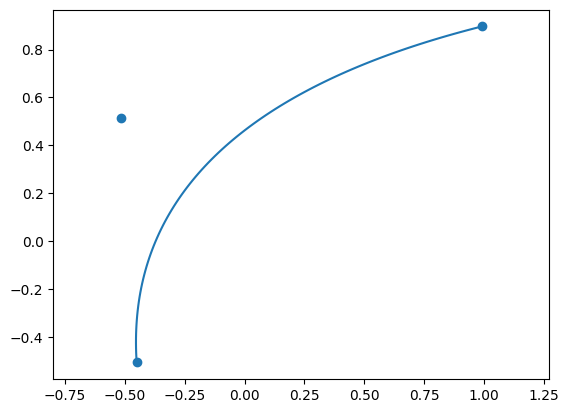

In [8]:
curve = QuadBezier()
curve.random(min=-1,max=1)
curve.plot()

# print("Adding random obstacles")
# for i in range(0,3):
#     curve.add_random_obstacle(min_x=min(curve.p0.x,curve.p2.x), max_x=max(curve.p0.x,curve.p2.x),
#                               min_y=min(curve.p0.y,curve.p2.y), max_y=max(curve.p0.y,curve.p2.y),
#                               min_radius=0.05, max_radius=0.5)
# curve.plot()

# print("Simultaniously optimizing arc-length and curvature")
# curve.optimize()
# curve.plot()

In [200]:
image_to_work = contour[14]

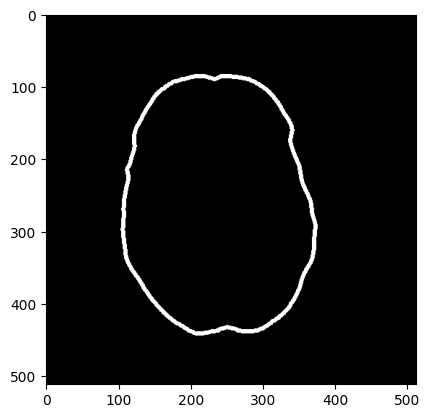

In [201]:
plt.imshow(image_to_work,cmap = "gray")
plt.show()

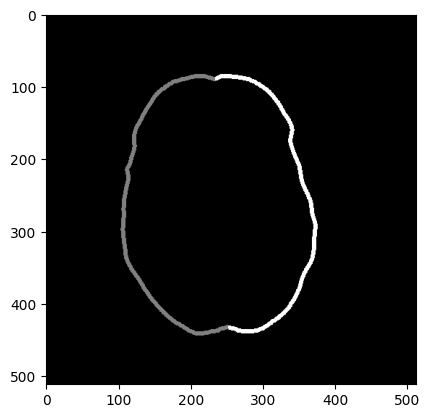

In [352]:
import numpy as np
import matplotlib.pyplot as plt

# Define two points (x1, y1) and (x2, y2)
ml_coordinates = np.argwhere(mls_arr[14]==1)
(x1,y1) = ml_coordinates[0]
(x2,y2) = ml_coordinates[-1]

# Calculate the slope (m) and y-intercept (b)
m = (y2 - y1) / (x2 - x1)
b = y1 - m * x1

# Create an empty mask
seperator_mask = np.zeros(image_to_work.shape, dtype=np.uint8)

for x in range(image_to_work.shape[0]):
    for y in range(image_to_work.shape[1]):
        if y >= m * x + b:
            seperator_mask[x, y] = 2
        else :
            seperator_mask[x, y] = 1

final_image_to_work = seperator_mask*image_to_work
plt.imshow(final_image_to_work, cmap='gray')
plt.show()

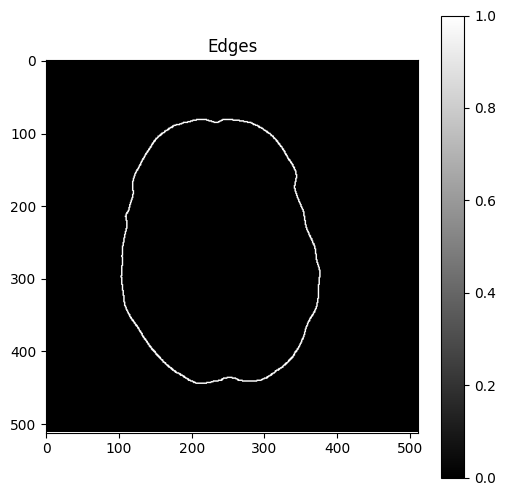

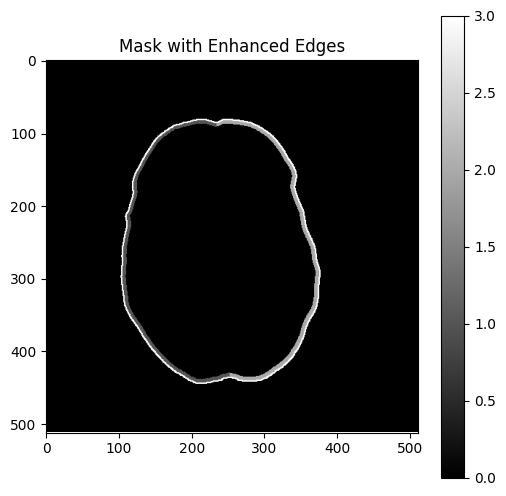

In [463]:
# Identify edge pixels
image_to_work_with_enhance_edges = icv_mask_arr[14].copy()

final_image_to_work_with_enhance_edges = final_image_to_work.copy()

edge_mask = cv2.Canny(image_to_work_with_enhance_edges.astype(np.uint8), 0, 1)  # Using Canny edge detection


# Dilate the edge pixels to make the edges thicker
kernel_size = 2  # Adjust this to control the thickness of the edges
dilated_edge_mask = cv2.dilate(edge_mask, np.ones((kernel_size, kernel_size), np.uint8))

# Set the intensity of the thickened edge pixels to a new value (3)
thick_edge_intensity = 3
image_to_work_with_enhance_edges[dilated_edge_mask > 0] = thick_edge_intensity

final_image_to_work_with_enhance_edges[image_to_work_with_enhance_edges==3] = 3

plt.figure(figsize=(6, 6))
plt.imshow(image_to_work_with_enhance_edges ==3, cmap='gray')
plt.title('Edges')
plt.colorbar()
plt.show()

# Display the original mask with edges enhanced
plt.figure(figsize=(6, 6))
plt.imshow(final_image_to_work_with_enhance_edges, cmap='gray')
plt.title('Mask with Enhanced Edges')
plt.colorbar()
plt.show()



In [434]:
left_contour_mask =  (final_image_to_work == 1)*1
right_contour_mask = (final_image_to_work ==2)*1
left_coordinates = np.argwhere(skeletonize(left_contour_mask)*1==1)
right_coordinates = np.argwhere(skeletonize(right_contour_mask)*1==1)

In [435]:
len(left_coordinates)

477

In [436]:
len(right_coordinates)

455

In [437]:
target_distance = 90
target_slope = 1

def query_two_points(coordinates, target_distance , target_slope):

    # Initialize variables to store the queried coordinates
    query_coord1 = None
    query_coord2 = None

    # Initialize variables to store the best match for distance and slope
    best_distance_diff = float('inf')
    best_slope_diff = float('inf')

    # Loop through the list of coordinates and find pairs that match the criteria
    for i, (x1, y1) in enumerate(coordinates):
        for j, (x2, y2) in enumerate(coordinates[i+1:], start=i+1):
            distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            slope = (y2 - y1) / (x2 - x1) if (x2 - x1) != 0 else float('inf')

            distance_diff = abs(target_distance - distance)
            slope_diff = abs(target_slope - slope)

            if distance_diff < best_distance_diff and slope_diff < best_slope_diff:
                best_distance_diff = distance_diff
                best_slope_diff = slope_diff
                query_coord1 = (x1, y1)
                query_coord2 = (x2, y2)
            
    return query_coord1 , query_coord2

In [438]:
point1 ,point2 =  query_two_points(left_coordinates, target_distance , target_slope)

In [439]:
def get_point_on_perp_bisector(point1,point2,distance) :
    
    x1,y1 = point1 
    x2,y2 = point2
    # Calculate the midpoint between the two given points
    midpoint = (int((x1 + x2) / 2), int((y1 + y2) / 2))
    intersection_x , intersection_y = midpoint
    
    original_slope = (y2 - y1)/(x2-x1)
    perpendicular_slope = -1 / original_slope
    
    perpendicular_intercept = midpoint[1] - perpendicular_slope * midpoint[0]
    
    # Calculate the angle of the line with respect to the x-axis
    theta = np.arctan(perpendicular_slope)

    # Calculate the x and y components of the desired points
    dx = distance * np.cos(theta)
    dy = distance * np.sin(theta)

    # Calculate the two points on the perpendicular bisector
    point1_perpendicular = (int(intersection_x + dx), int(intersection_y + dy))
    point2_perpendicular = (int(intersection_x - dx), int(intersection_y - dy))
    
    return point1_perpendicular , point2_perpendicular



In [509]:
point1_perpendicular, point2_perpendicular =  get_point_on_perp_bisector(point1,point2,10) 

In [510]:
curve = QuadBezier(p0x = point1[0], p0y = point1[1],p1x = point2_perpendicular[0] , p1y = point2_perpendicular[1],
                  p2x = point2[0] , p2y = point2[1])


In [511]:
final_curve = curve.calc_curve()

In [512]:
curve_coordinates = zip(final_curve[0],final_curve[1])

In [513]:
final_curve_mask = np.zeros(final_image_to_work.shape)
for pair in curve_coordinates :
    final_curve_mask[int(pair[0])][int(pair[1])] = 3

In [514]:
kernel_size = 2  # Adjust this to control the thickness of the edges
dilated_curve_mask = cv2.dilate(final_curve_mask, np.ones((kernel_size, kernel_size), np.uint8))

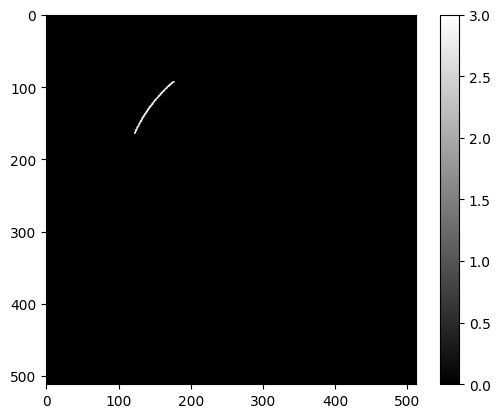

In [515]:
plt.imshow(dilated_curve_mask, cmap='gray')
plt.colorbar()
plt.show()

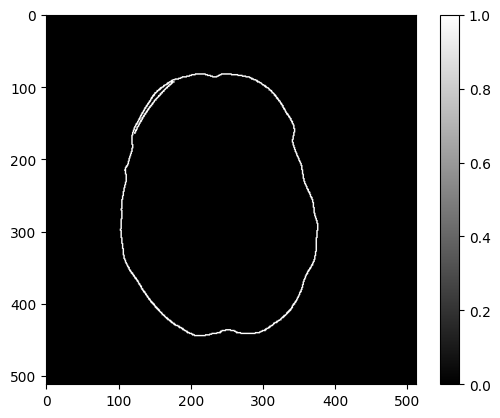

In [466]:
final_image_to_work_with_enhance_edges[dilated_curve_mask == 3] = 3
plt.imshow(final_image_to_work_with_enhance_edges == 3, cmap='gray')
plt.colorbar()
plt.show()

In [470]:
final_artificial_sdh_mask = binary_closing(final_image_to_work_with_enhance_edges == 3 , disk(3)) - (image_to_work_with_enhance_edges ==3)*1

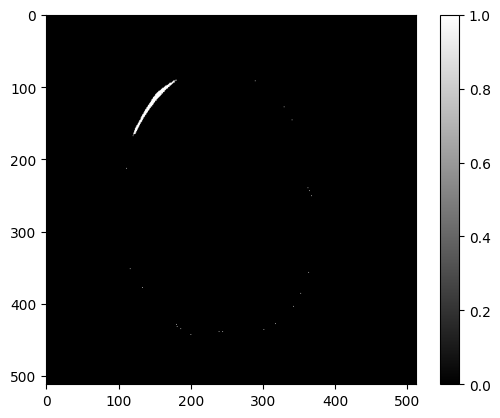

In [471]:
plt.imshow(final_artificial_sdh_mask, cmap='gray')
plt.colorbar()
plt.show()

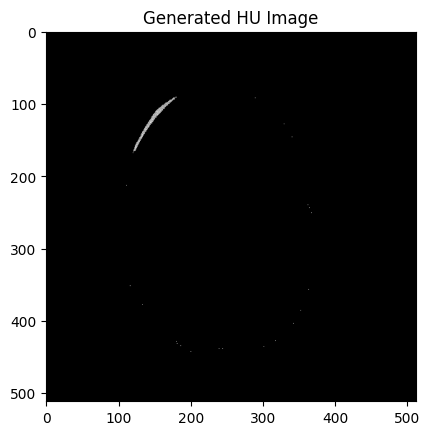

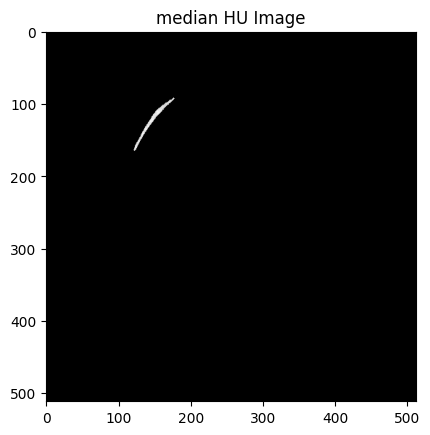

In [594]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import norm

# Calculate the mean and standard deviation of the original HU values
mean = np.mean(filtered_hu_values)
std = np.std(filtered_hu_values)

# Generate Gaussian-distributed HU values based on the mean and standard deviation
gaussian_hu_values = np.random.normal(mean, std, size=np.sum(final_artificial_sdh_mask > 0))

# Apply the generated HU values to the binary mask
generated_hu_image = np.zeros(final_artificial_sdh_mask.shape)
generated_hu_image[final_artificial_sdh_mask > 0] = gaussian_hu_values.astype(np.int16)


plt.imshow(generated_hu_image, cmap='gray')
plt.title('Generated HU Image')
plt.show()

plt.imshow(median(generated_hu_image,disk(2)), cmap='gray')
plt.title('median HU Image')
plt.show()


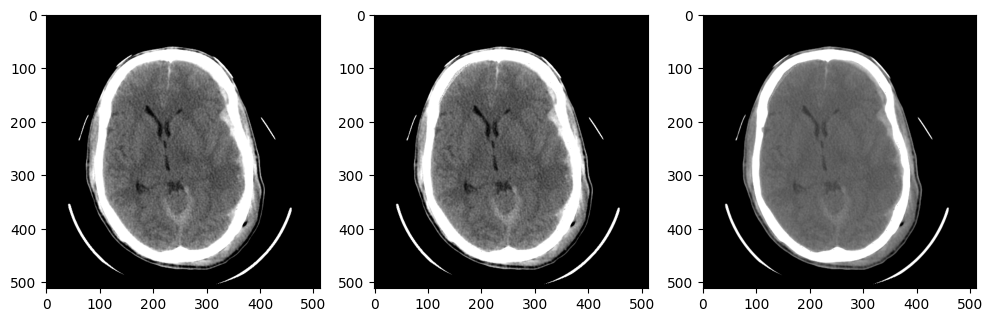

In [611]:
new_arr = arr[14].copy()
artifical_sdh_mask_coordinates = np.argwhere(final_artificial_sdh_mask == 1)
for (x,y) in artifical_sdh_mask_coordinates :
    new_arr[x][y] = generated_hu_image[x][y]
plt.figure(figsize = (12,6))
plt.subplot(131)
plt.imshow(brain_window(arr[14]),cmap = "gray")
# plt.show()
plt.subplot(132)
plt.imshow(brain_window(new_arr),cmap = "gray")
# plt.show()
plt.subplot(133)
plt.imshow(blood_window(new_arr),cmap = "gray")
plt.show()

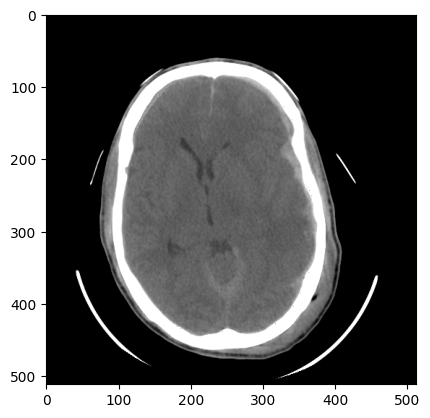

In [585]:
plt.imshow(blood_window(new_arr),cmap = "gray")
plt.show()

In [534]:
eroded_sdh_mask_arr = binary_erosion(sdh_mask_arr,ball(1))

In [535]:
hu_values = arr[eroded_sdh_mask_arr> 0].ravel()

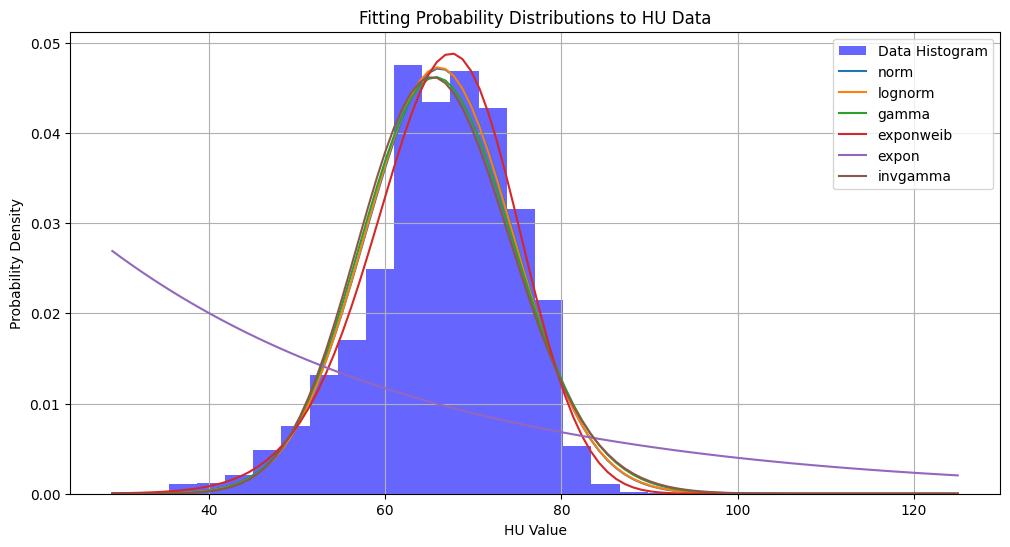

In [606]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Simulated HU data (replace this with your actual data)
hu_data = hu_values

# Fitting distributions
distributions = [stats.norm, stats.lognorm, stats.gamma, stats.exponweib, stats.expon,stats.invgamma]
fit_results = []

for dist in distributions:
    params = dist.fit(hu_data)
    fit_results.append(params)

# Plot histogram and distribution fits
plt.figure(figsize=(12, 6))
plt.hist(hu_data, bins=30, density=True, alpha=0.6, color='blue', label='Data Histogram')

for dist, params in zip(distributions, fit_results):
    x = np.linspace(min(hu_data), max(hu_data), 100)
    y = dist.pdf(x, *params)
    plt.plot(x, y, label=dist.name)

plt.title('Fitting Probability Distributions to HU Data')
plt.xlabel('HU Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


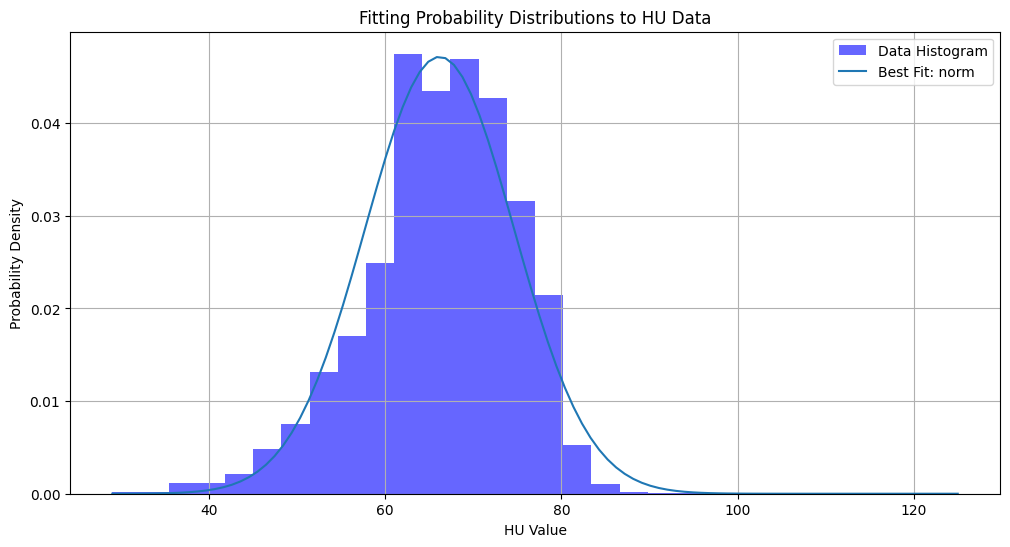

Kolmogorov-Smirnov Test Results:
expon: KS Statistic = 0.4119, p-value = 0.0000
gamma: KS Statistic = 0.0738, p-value = 0.0000
lognorm: KS Statistic = 0.0690, p-value = 0.0000
norm: KS Statistic = 0.0679, p-value = 0.0000
exponweib: KS Statistic = 0.0459, p-value = 0.0000


In [559]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Simulated HU data (replace this with your actual data)
hu_data = hu_values

# List of distributions to test
distributions = [stats.norm, stats.lognorm, stats.gamma, stats.exponweib, stats.expon]

# Perform Kolmogorov-Smirnov test for each distribution
ks_results = []
for dist in distributions:
    ks_statistic, p_value = stats.kstest(hu_data, dist.cdf, args=dist.fit(hu_data))
    ks_results.append((dist.name, ks_statistic, p_value))

# Sort the results based on p-values (lower p-value indicates poorer fit)
ks_results.sort(key=lambda x: x[2])

# Plot histogram and the best-fit distribution
best_fit_dist = distributions[0]  # Select the distribution with the lowest p-value
params = best_fit_dist.fit(hu_data)
x = np.linspace(min(hu_data), max(hu_data), 100)
y = best_fit_dist.pdf(x, *params)

plt.figure(figsize=(12, 6))
plt.hist(hu_data, bins=30, density=True, alpha=0.6, color='blue', label='Data Histogram')
plt.plot(x, y, label=f'Best Fit: {best_fit_dist.name}')

plt.title('Fitting Probability Distributions to HU Data')
plt.xlabel('HU Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

print("Kolmogorov-Smirnov Test Results:")
for name, ks_statistic, p_value in ks_results:
    print(f"{name}: KS Statistic = {ks_statistic:.4f}, p-value = {p_value:.4f}")


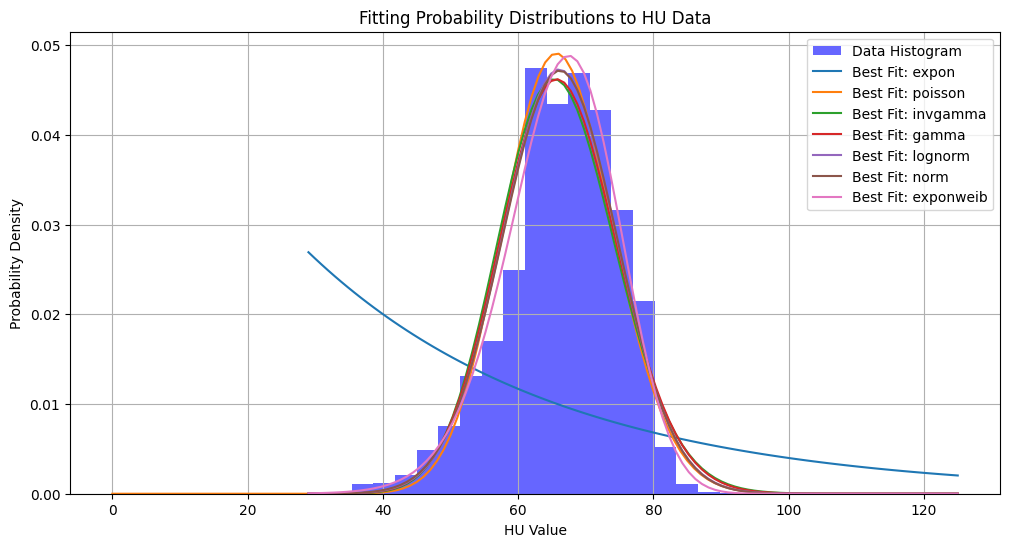

Kolmogorov-Smirnov Test Results:
expon: KS Statistic = 0.4119, p-value = 0.0000
poisson: KS Statistic = 0.1016, p-value = 0.0000
invgamma: KS Statistic = 0.0828, p-value = 0.0000
gamma: KS Statistic = 0.0738, p-value = 0.0000
lognorm: KS Statistic = 0.0690, p-value = 0.0000
norm: KS Statistic = 0.0679, p-value = 0.0000
exponweib: KS Statistic = 0.0459, p-value = 0.0000


In [637]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Simulated HU data (replace this with your actual data)
hu_data = hu_values

# List of distributions to test
distributions = [stats.norm, stats.lognorm, stats.gamma, stats.exponweib, stats.expon, stats.invgamma, stats.poisson]

# Perform Kolmogorov-Smirnov test for each distribution
ks_results = []
for dist in distributions:
    if dist == stats.poisson:
        mu = np.mean(hu_data)  # Estimate parameter for Poisson distribution
        ks_statistic, p_value = stats.kstest(hu_data, dist.cdf, args=(mu,))
    else:
        ks_statistic, p_value = stats.kstest(hu_data, dist.cdf, args=dist.fit(hu_data))
    ks_results.append((dist.name, ks_statistic, p_value))

# Sort the results based on p-values (lower p-value indicates poorer fit)
ks_results.sort(key=lambda x: x[2])

# Plot histogram and the best-fit distributions
plt.figure(figsize=(12, 6))
plt.hist(hu_data, bins=30, density=True, alpha=0.6, color='blue', label='Data Histogram')

for name, _, _ in ks_results:
    dist = next(dist for dist in distributions if dist.name == name)
    if dist == stats.poisson:
        mu = np.mean(hu_data)  # Estimate parameter for Poisson distribution
        x = np.arange(0, max(hu_data) + 1)
        y = dist.pmf(x, mu)
    else:
        params = dist.fit(hu_data)
        x = np.linspace(min(hu_data), max(hu_data), 100)
        y = dist.pdf(x, *params)
    plt.plot(x, y, label=f'Best Fit: {name}')

plt.title('Fitting Probability Distributions to HU Data')
plt.xlabel('HU Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

print("Kolmogorov-Smirnov Test Results:")
for name, ks_statistic, p_value in ks_results:
    print(f"{name}: KS Statistic = {ks_statistic:.4f}, p-value = {p_value:.4f}")


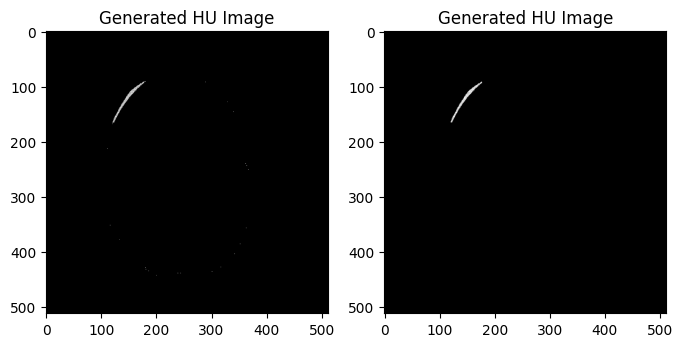

In [640]:
plt.figure(figsize = (8,4))

plt.subplot(121)
plt.imshow(generated_hu_image, cmap='gray')
plt.title('Generated HU Image')
plt.subplot(122)
plt.imshow(median(generated_hu_image,disk(1)), cmap='gray')
plt.title('Generated HU Image')
plt.show()

In [761]:
final_artificial_sdh_mask =  binary_dilation(binary_opening(final_artificial_sdh_mask , disk(1)), disk(1))*icv_mask_arr[14]


In [762]:
dilated_final_artificial_sdh_mask = binary_dilation(final_artificial_sdh_mask,disk(7))*icv_mask_arr[14]

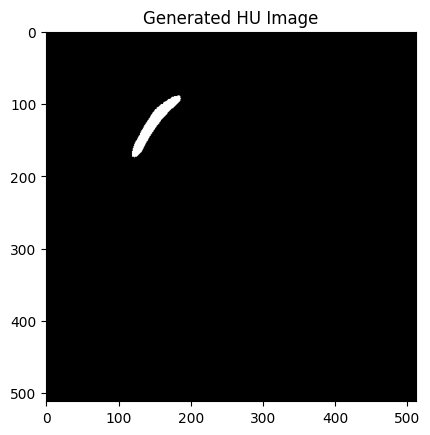

In [763]:
plt.imshow(dilated_final_artificial_sdh_mask, cmap='gray')
plt.title('Generated HU Image')
plt.show()

In [764]:
params = stats.gamma.fit(hu_values)
synthetic_data = stats.gamma.rvs(*params, size=np.sum(final_artificial_sdh_mask > 0))

# Apply the generated HU values to the binary mask
generated_hu_image = np.zeros(final_artificial_sdh_mask.shape)
generated_hu_image[final_artificial_sdh_mask > 0] = synthetic_data.astype(np.int16)

In [765]:
generate_hu_values = median(generated_hu_image,disk(2))

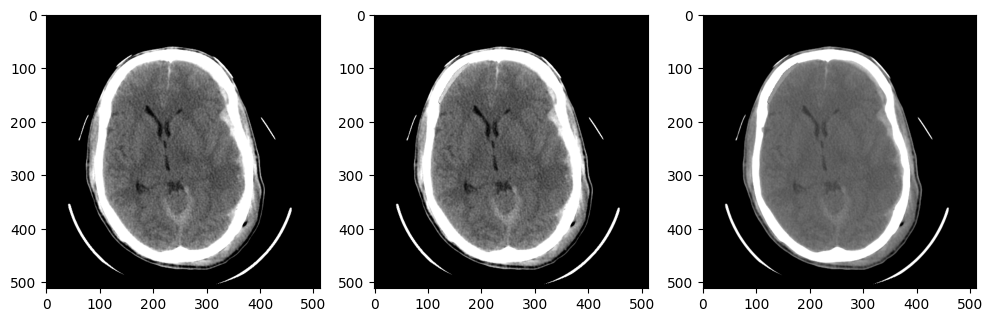

In [766]:
new_arr = arr[14].copy()
artifical_sdh_mask_coordinates = np.argwhere(final_artificial_sdh_mask == 1)
for (x,y) in artifical_sdh_mask_coordinates :
    new_arr[x][y] = generate_hu_values[x][y]
    
plt.figure(figsize = (12,6))
plt.subplot(131)
plt.imshow(brain_window(arr[14]),cmap = "gray")
# plt.show()
plt.subplot(132)
plt.imshow(brain_window(new_arr),cmap = "gray")
# plt.show()
plt.subplot(133)
plt.imshow(blood_window(new_arr),cmap = "gray")
plt.show()

In [ ]:
arr[14],

In [790]:
import cv2
import numpy as np

blur_kernel_size = 3
blurred_gaussian_image = cv2.GaussianBlur(generated_hu_image, (blur_kernel_size, blur_kernel_size), 0)

blurred_gaussian_image = blurred_gaussian_image.astype(arr[14].dtype)


# Alpha blend the blurred Gaussian image and the original image
alpha = 0.3  # Adjust this value for the desired blending strength
blended_image = cv2.addWeighted(arr[14], 1 - alpha, blurred_gaussian_image, alpha, 3)

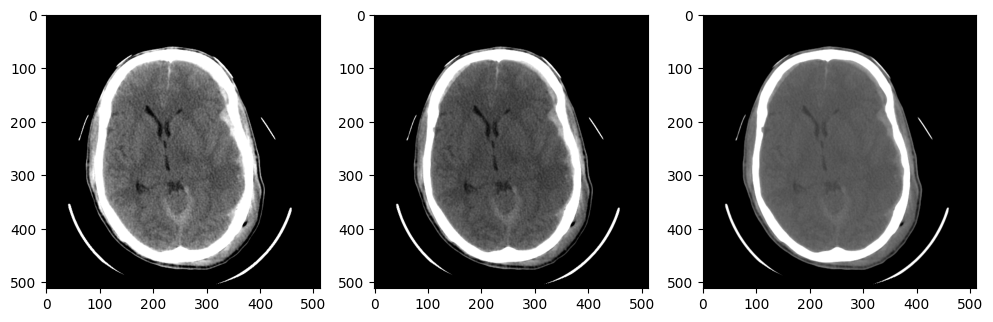

In [791]:
plt.figure(figsize = (12,6))
plt.subplot(131)
plt.imshow(brain_window(arr[14]),cmap = "gray")
# plt.show()
plt.subplot(132)
plt.imshow(brain_window(blended_image),cmap = "gray")
# plt.show()
plt.subplot(133)
plt.imshow(blood_window(blended_image),cmap = "gray")
plt.show()

In [124]:
left_hemisphere = (final_image_to_work == 1)*1

NameError: name 'final_image_to_work' is not defined

In [795]:
np.unique(region_labels)

array([1], dtype=uint8)

In [811]:
import numpy as np

# Find indices of non-zero elements (curve pixels)
curve_indices = np.argwhere(left_hemisphere == 1)

# Define the ratios for the three sections
ratio_section1 = 0.3
ratio_section2 = 0.35
ratio_section3 = 0.35

# Calculate total number of curve pixels
total_pixels = len(curve_indices)

# Calculate lengths of the three sections
length_section1 = int(total_pixels * ratio_section1)
length_section2 = int(total_pixels * ratio_section2)
length_section3 = total_pixels - length_section1 - length_section2

# Divide the curve indices into three sections
section1_indices = curve_indices[:length_section1]
section2_indices = curve_indices[length_section1:length_section1+length_section2]
section3_indices = curve_indices[length_section1+length_section2:]

# Create binary masks for each section
section1_mask = np.zeros_like(left_hemisphere)
section2_mask = np.zeros_like(left_hemisphere)
section3_mask = np.zeros_like(left_hemisphere)

for idx in section1_indices:
    section1_mask[idx[0], idx[1]] = 1

for idx in section2_indices:
    section2_mask[idx[0], idx[1]] = 1

for idx in section3_indices:
    section3_mask[idx[0], idx[1]] = 1



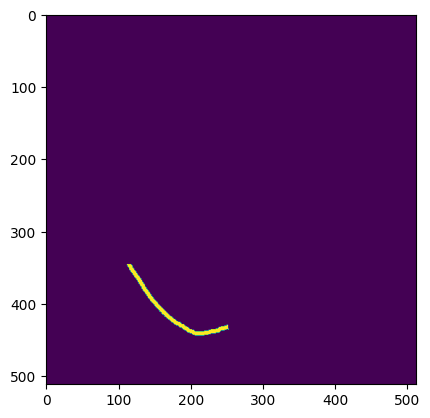

In [812]:
plt.imshow(section3_mask)  # Use vmin and vmax to match region labels
plt.show()

In [2]:
import pandas as pd
df = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/fusion_v5_crop_new_test_set.csv")

In [5]:
df.drop_duplicates(subset=["StudyUID"]).to_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/fusion_v5_crop_new_test_set.csv",index =False)



In [17]:
df = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_train.csv")

In [18]:
normal_study_uids = df[(df["NORMAL_BRAIN"] == 1) & (df["Status"] == "train")].StudyUID.values

In [61]:
import h5py
base_path = "/cache/fast_data_nas8/qer/sujith"      
path = os.path.join(base_path, '1.2.840.113619.2.278.3.2831165733.829.1325445117.576')
datapath = path + ".h5"
f2 = h5py.File(datapath, "r")
arr = f2["image"]

In [63]:
f2 = h5py.File(datapath, "r")

In [64]:
arr = f2["image"]

In [65]:
arr.shape

(32, 512, 512)

In [123]:
plot_scans([blood_window(arr)],[""])

interactive(children=(IntSlider(value=0, description='z', max=35), Output()), _dom_classes=('widget-interact',…

In [73]:
df = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/inference_new_test_set.csv")

Columns (1,27,83,121,140) have mixed types. Specify dtype option on import or set low_memory=False.


In [102]:
df_100 = df[df["NumSlices"]>70]

In [90]:
df[df["StudyUID"]== '1.2.840.113619.2.278.3.2831165733.829.1325445117.576'].FilePath.values[0]

'/data_nas3/processed/hct/Test_set/test_set_1/sampled/1.2.840.113619.2.278.3.2831165733.829.1325445117.576.nii.gz'

In [105]:

for i in df_100.index :
    study_uid = df_100.loc[i , "StudyUID"]
    filepath = df_100.loc[i , "FilePath"]
    path = os.path.join(filepath)
    img = sitk.ReadImage(filepath)
    z_shape = img.GetSize()[2]
    print(z_shape ,df_100.loc[i , "NumSlices"])
    

36 288.0
36 256.0
33 233.0
33 271.0
32 128.0
38 304.0
36 288.0
36 256.0
40 160.0
54 432.0
38 304.0
34 272.0
36 288.0
41 288.0
34 272.0
36 288.0
36 288.0
34 272.0
32 256.0
34 272.0
40 320.0
41 288.0
76 608.0
36 288.0
32 256.0
50 400.0
52 416.0
38 304.0
36 288.0
34 272.0
32 256.0
32 256.0
36 288.0
34 272.0
36 288.0
34 272.0
56 448.0
40 320.0
36 288.0
36 144.0
36 288.0
37 303.0
36 288.0
38 304.0
32 128.0
38 304.0
30 240.0
30 240.0
29 240.0
30 240.0
39 197.0
36 144.0
38 272.0
32 256.0
32 128.0
30 240.0
32 128.0
36 288.0
52 416.0
36 288.0
36 288.0
32 256.0
34 272.0
40 320.0
36 144.0
32 256.0
33 133.0
36 288.0
41 288.0
36 256.0
32 128.0
34 272.0
36 288.0
32 256.0
36 144.0
36 144.0
28 112.0
35 177.0
47 331.0
34 272.0
31 255.0
34 272.0
38 304.0
36 288.0
32 128.0
36 254.0
32 128.0
28 224.0
48 384.0
36 288.0
40 81.0
34 272.0
32 256.0
36 144.0
36 144.0
36 144.0
32 128.0
33 269.0
32 128.0
34 272.0
48 384.0
38 304.0
28 112.0
32 256.0
29 239.0
30 240.0
34 272.0
34 272.0
34 272.0
44 352.0
28 224.0
34

KeyboardInterrupt: 

In [104]:
df_100.columns

Index(['SeriesUID', 'CTASeriesUID', 'StudyUID', 'Source', 'FilePath',
       'NumSlices', 'SliceThickness', 'Manufacturer', 'ConvolutionKernel',
       'nlp__ICH',
       ...
       'ConvSTANDARD', 'blend_score', 'infarcts_decision',
       'acute_infarcts_decision', 'convlstm_v4_decision',
       'uniformer_v1_decision', 'seresnet101_v3_decision',
       'seresnet50_v8_decision', 'seresnet50_v11_decision', 'blend_decision'],
      dtype='object', length=211)

In [121]:

series_dict = db.dicoms.find_one({"_id": '1.2.840.113619.2.284.3.2831168021.160.1374282537.443'})
filepaths = [x['FilePath'] for x in series_dict["InstancesList"]]
filepaths = [filepath.replace( "/data_nas2/raw/" , "/data_nas3/raw/hct/")  for filepath in filepaths]


sitk_img = load_raw_sitk_img(filepaths)
arr = sitk.GetArrayFromImage(sitk_img)

# # Normal CT scan
# base_path = "/cache/fast_data_nas8/qer/sujith"      
# path = os.path.join(base_path, '1.2.840.113619.2.278.3.2831165733.829.1325445117.576')

[2023-08-17 10:21:54 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00


In [122]:
arr

array([[[-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        ...,
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024]],

       [[-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        ...,
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024]],

       [[-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        ...,
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -30

In [106]:
df_train = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_train.csv")

In [108]:
df_train[df_train["StudyUID"] == "1.2.840.113619.2.278.3.2831165733.829.1325445117.576" ]

,StudyUID,PatientID,Status,Filepath,SeriesUID,Batch,Remarks,ICH,SDH,EDH,...,CONFIRMED_HCT,POSTOP,NORMAL_BRAIN,UNCERTAIN_REPORT,ANY,crop,PATIENT_AGE,MANUFACTURER,ignore,dcmpath


In [120]:
df_train[df_train["NORMAL_BRAIN"] == 1].loc[8].SeriesUID

'1.2.840.113619.2.284.3.2831168021.160.1374282537.443'